# Detecting introgression in Anopheles mosquito genomes using a reconciliation-based approach
## Notebook 1: HGTs and introgression events

## Cedric Chauve, Jingxue Feng,  Liangliang Wang
### Departments of Mathematics and Statistics, Simon Fraser University
#### Contact: cedric.chauve@sfu.ca
#### Date: August 2nd, 2018

In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

## Preamble
This notebook contains the code required to generate the figures related to inferred Horizontal Gene Transfers (HGT) and introgression events for the paper *Detecting introgression in Anopheles mosquito genomes using a reconciliation-based approach*, published in the proceedings of RECOMB-CG 2018.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# AUXILIARY FUNCTIONS

# Reading orthogroups data and creating a data frame
# Remark: in this notebook we use equivalently orthogroup and family
# Output: a pair (GENES,OG) of data frames:
# - GENES = 'species', 'chr', 'sign', 'start', 'end', 'orthogroup'
# - OG = columns indexed by species (number of genes of the orthogroup per species)
def read_orthogroups(FILE):
    # FILE = path to the orthogroups file
    
    OG_file = open(FILE,'r').readlines()
    GENES_AUX = {}  # Array of genes
    OG_AUX = {}     # Array of orthogroups
    for l in OG_file:
        # reading gene data
        if l[0]!="#":
            gene = l.rstrip().split()
            # AGAMB	2L	EOG091709JI	AGAP004680	+	271285	271815	1	271285-271815
            (species,chr,og,name,sign,start,end) = (gene[0],gene[1],gene[2],gene[3],gene[4],int(gene[5]),int(gene[6]))
            # Populating data structures
            GENES_AUX[name] = (species,chr,sign,start,end,og)
            # Last three parameters: kept after MrBayes, kept after ALE, kept after post-ALE selection
            OG_AUX[og] = {}
    # Data frame for genes
    GENES = pd.DataFrame.transpose(pd.DataFrame(GENES_AUX))
    GENES.columns=['species', 'chr', 'sign', 'start', 'end', 'orthogroup']
    # Data frame for orthogroups
    for og in OG_AUX.keys():
        OG_AUX[og]={s: False for s in SPECIES_ALL}
    for g in GENES_AUX.keys():
        og = GENES_AUX[g][5]
        s  = GENES_AUX[g][0]
        OG_AUX[og][s]=True
    OG = pd.DataFrame.transpose(pd.DataFrame(OG_AUX))
    OG.columns = SPECIES_ALL
    return((GENES,OG))

# Generating plots figures of the distribution of genome size (number of genes) and family size
def generate_images(DF,F1,F2):
    # DF  = orthogroups dataframe
    # F1  = path to the output file for the figure on the number of genes per genomes
    # F2  = path to the output file for the figure on the number of genes per family
    
    NBF = len(DF.orthogroup.unique()) # Number of families
    NBG = len(DF) # Number of genes
    
    genome_sizes = pd.DataFrame({'count' : DF.groupby('species').size()}) 
    pltsgen_size = genome_sizes.plot(kind='bar',legend=None, grid=True, figsize=(10,5), fontsize=12)
    pltsgen_size.set_xlabel('species', fontsize=14)
    pltsgen_size.set_ylabel('number of genes', fontsize=14)
    pltsgen_size.set_title('Genome size distribution (#genes='+str(NBG)+')', fontsize=14)
    plt.tight_layout()
    plt.savefig(F1) 
    
    family_sizes_aux = pd.DataFrame({'count' : DF.groupby('orthogroup').size()}).reset_index() 
    family_sizes_aux.columns = ['orthogroup','size']
    family_sizes = pd.DataFrame({'count' : family_sizes_aux.groupby('size').size()})
    pltfam_size = family_sizes.plot(kind='bar',legend=None, grid=True, figsize=(10,5), fontsize=12)
    pltfam_size.set_xlabel('family size', fontsize=14)
    pltfam_size.set_ylabel('number of families', fontsize=14)
    pltfam_size.set_title('Family size distribution (#families='+str(NBF)+')', fontsize=14)
    plt.tight_layout()
    plt.savefig(F2) 
    
    
# Reading the MrBayes Summary file  filtered to keep only families with
# at least S MrBayes samples and RF distance at most RF between the amalgamated
# reconciled gene trees computed by ALE using the two runs of MrBayes
# Output: data frame indexed by orthogroup: 'orthogroup','samples','RF'
def read_MrB_ALE_summary(FILE,S,RF):
    # FILE = path to the MrBayes+ALE summary file
    # S = minimum number of samples to keep a family
    # RF = maximum normalized Robinson-Foulds distance between the two trees
    
    MRB_file = open(FILE,'r').readlines()
    MRB_AUX={}
    for l in MRB_file: 
        # reading family data
        if l[0]!="#":
            family = l.rstrip().split()
            #  EOG09170001 18990 17 17 0.00000
            og = family[0]
            (samples,rf) = (int(family[1]),float(family[4]))
            # Populating data structures
            MRB_AUX[og] = (samples,rf)
        
    # Data frame from the whole summary file
    MRB_1 = pd.DataFrame.from_dict(MRB_AUX, orient='index').reset_index().fillna(0)
    MRB_1.columns=['orthogroup','samples','RF']
    # Filtering for K
    MRB_2 = MRB_1.loc[MRB_1['samples'] >= S]
    MRB_3 = MRB_2.loc[MRB_2['RF'] <= RF]
    return(MRB_3)

# Extracting the HGTs from the selected orthogroups and storing in a file suffixed by "FILTERED"
def filter_HGT(FILE,OG,OUTPUT):
    # FILE = path to the ALE HGT summary file
    # OG = orthogroups data frame
    # OUTPUT = output file
    HGT_file = open(FILE,'r').readlines()
    NB_TRANSFERS_PRE_FILTERING = len(HGT_file) 
    HGT_filtered_file = open(OUTPUT,'w')
    NB_TRANSFERS_POST_FILTERING=0
    HGT_AUX={}
    for l in HGT_file: 
        if l[0]!="#":
            l1 = l.rstrip().split()
            og = l1[0]
            if og in OG:
                NB_TRANSFERS_POST_FILTERING+=1
                HGT_filtered_file.write(l)
        else:
            HGT_filtered_file.write(l)
    HGT_filtered_file.close()
    return((NB_TRANSFERS_PRE_FILTERING,NB_TRANSFERS_POST_FILTERING))

# Reading a transfers file to create a data frame of transfers with frequency >= F for both runs
# Output: data frame 'orthogroup','donor_receptor','frequency' where donor_receptor is an ordered pair of species
def read_HGT(FILE,F):
    # FILE = path to the ALE HGT summary file
    # F = minimum frequency to keep a HGT
    
    HGT_file = open(FILE,'r').readlines()
    HGT_AUX={}
    for l in HGT_file: 
        # reading HGT data
        if l[0]!="#":
            l1 = l.rstrip().split()
            (og,run,donor,receptor,freq)=(l1[0],l1[1],l1[2],l1[3],float(l1[4]))
            if freq>=F:
                HGT_AUX[(og,donor,receptor,run)]=freq                
    # Creating the final structure with a mean of the frequencies                    
    index=0
    HGT_ALL_AUX = {}
    for (og,donor,receptor,run) in HGT_AUX.keys():
        if run=='run1':
            freq1 = HGT_AUX[(og,donor,receptor,'run1')]
            freq2 = HGT_AUX[(og,donor,receptor,'run2')]
            if freq1>0 and freq2>0:
                HGT_ALL_AUX[index] = (og,(donor,receptor),np.mean([freq1,freq2]))
                index+=1
     # Creating data frames
    HGT_ALL         = pd.DataFrame.from_dict(HGT_ALL_AUX, orient='index')
    HGT_ALL.columns = ['orthogroup','donor_receptor','frequency']               
    return(HGT_ALL)

# Reading MaxTiC constraints
def read_constraints(FILE):
    # FILE = path to the MaxTiC constraints file
    FF = open(FILE,'r').readlines()
    w = 0.0
    n = 0
    for l in FF:
        if l[0]!='0':
            l1=l.rstrip().split()
            l2=l1[0].split(',')
            n += 1
            o = l2[0]# older species
            y = l2[1]# younger species
            w += float(l1[1])# weight
    return((n,w))

# Aggregating the HGTs per introgression event
def aggregate_HGT(HGT):
    # HGT = HGT data frame
    HGT_AGG_AUX1 = HGT.groupby('donor_receptor')['frequency'].sum().reset_index()
    HGT_AGG_AUX2 = HGT.groupby('donor_receptor')['frequency'].size().reset_index()
    HGT_AGG = HGT_AGG_AUX1.merge(HGT_AGG_AUX2, left_on='donor_receptor', right_on='donor_receptor')
    HGT_AGG.columns=['donor_receptor','frequency','number']
    return(HGT_AGG)

# Filtering introgression events to have support by at least N families and CF cumulated requency
def filter_introgression(HGT_AGG,N,CF,IMG):
    # HGT_AGG = aggregaterd HGT data frame
    # N, CF = see comment above
    # IMG = generated image of the summary of introgression events
    HGT_AGG_F1 = HGT_AGG[HGT_AGG['number']>=N]
    HGT_AGG_F2 = HGT_AGG_F1[HGT_AGG_F1['frequency']>=CF]
    HGT_AGG_F2.sort_values(by='number',ascending=False).plot(kind='bar', x='donor_receptor', grid=True, figsize=(10,5), fontsize=10)
    plt.tight_layout()
    plt.savefig(IMG)
    return(HGT_AGG_F2)

# Extracting the families involved in a given event (DONOR,RECEPTOR) and their size
# Creates a data frame 'frequency','nb_species','gambia_sp','outg_sp','asian_sp'
# Creates a CSV file output/files/'+DONOR+'_'+RECEPTOR+'_'+SUFFIX
def extract_introg_event_families(HGT,OG,DONOR,RECEPTOR,SUFFIX):
    HGT_SPECIFIC    = HGT.loc[HGT['donor_receptor']==(DONOR,RECEPTOR)]
    OG_SPECIFIC_AUX = {}
    for idx, row in HGT_SPECIFIC.iterrows():
        og      = row['orthogroup']
        freq    = row['frequency']
        species = OG.loc[og]
        nb_species     = 0
        nb_gambia_sp   = 0
        nb_outgroup_sp = 0
        nb_asian_sp    = 0
        for s in SPECIES_ALL:
            if species.loc[s]==True:
                nb_species+=1
        for s in SPECIES_GAMBIA:
            if species.loc[s]==True:
                nb_gambia_sp+=1
        for s in SPECIES_OUTGROUPS:
            if species.loc[s]==True:
                nb_outgroup_sp+=1
        for s in SPECIES_ASIANS:
            if species.loc[s]==True:
                nb_asian_sp+=1
        OG_SPECIFIC_AUX[og]=(freq,nb_species,nb_gambia_sp,nb_outgroup_sp,nb_asian_sp)
    OG_SPECIFIC = pd.DataFrame.from_dict(OG_SPECIFIC_AUX,orient='index')
    OG_SPECIFIC.columns = ['frequency','nb_species','gambia_sp','outg_sp','asian_sp']
    OG_SPECIFIC.to_csv('output/files/'+DONOR+'_'+RECEPTOR+'_'+SUFFIX, mode ='w', header = False, index = True, sep='\t')
    return(OG_SPECIFIC)

# Show support for specific introgression events
def show_support(EVENTS,OG_EVENT,HEADER):
    print('#'+HEADER)
    print('#donor\trec.\t#HGTs\tavgFreq\tcovAll\tcovGamb\tcovOutg\tcovAsian')
    for (X,Y) in  EVENTS:
        TAB = OG_EVENT[(X,Y)]
        COVERAGE  = round(TAB['nb_species'].mean(),3)
        COV_GAMB  = round(TAB['gambia_sp'].mean(),3)
        COV_OUTG  = round(TAB['outg_sp'].mean(),3)
        COV_ASIA  = round(TAB['asian_sp'].mean(),3)
        FREQUENCY = round(TAB['frequency'].mean(),3)
        NB_HGT    = len(TAB)
        print(X+'\t'+Y+'\t'+str(NB_HGT)+'\t'+str(FREQUENCY)+'\t'+str(COVERAGE)+'\t'+str(COV_GAMB)+'\t'+str(COV_OUTG)+'\t'+str(COV_ASIA))

### Data: species and orthogroups

In [3]:
# DATA: Species 
# Remark: the species names follow the convention described in the paper.
SPECIES_GAMBIA    = ['AGAMB','ACOLU','AARAB','AQUAD','AMERU','AMELA']# Gambiae complex
SPECIES_OUTGROUPS = ['ACHRI','AEPIR']# Outgroups to the Gambiae complex
SPECIES_ASIANS    = ['AMINI','ACULI','AFUNE','ASTES','ASTEI','AMACU']# Asian mosquitoes+An funestus
SPECIES_ALL       = SPECIES_GAMBIA+SPECIES_OUTGROUPS+SPECIES_ASIANS

In [4]:
# Reading orthogroups data
(GENES,ORTHOGROUPS) = read_orthogroups('input/ORTHOGROUPS_ODB9')

### Figure 2: genome size (number of genes) and orthogroup size distribution for all orthogroups

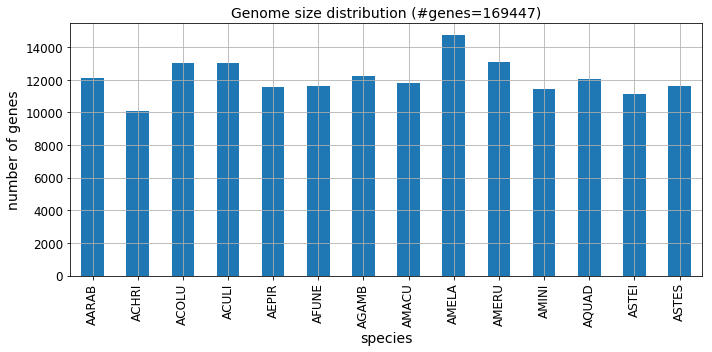

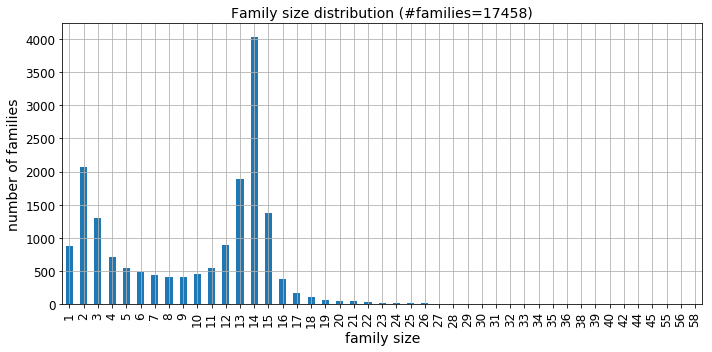

In [5]:
generate_images(GENES,'output/images/genome_sizes.png','output/images/family_sizes.png')

Results: files output/images/genome_sizes.png and output/images/family_sizes.png

<center><img src="output/images/genome_sizes.png" width=700px></center>

<center><img src="output/images/family_sizes.png" width=700px></center>

### Results of MrBayes
We compute the number of samples per orthogroups generated by MrBayes (minimum number over the two runs).

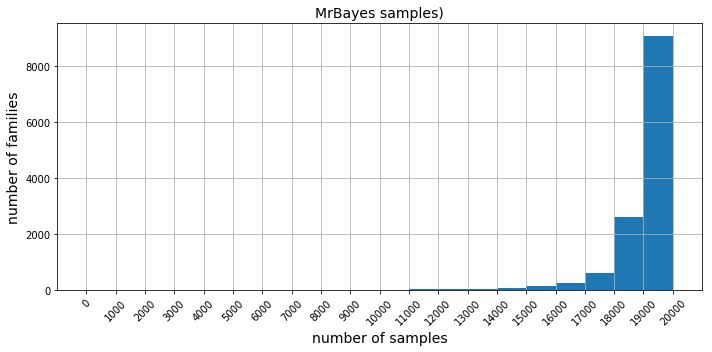

In [6]:
# Distribution of the number of samples per family
MRB_ALL = read_MrB_ALE_summary('input/MrBayes_ALE_summary.txt',1,1000)

pltmrb_samples = MRB_ALL.hist(column='samples',bins=20,grid=True,figsize=(10,5))
plt.xticks(np.arange(0,21000,1000), rotation=45)
plt.xlabel('number of samples', fontsize=14)
plt.ylabel('number of families', fontsize=14)
plt.title('MrBayes samples)', fontsize=14)
plt.tight_layout()
plt.savefig('output/images/mrb_samples_ALL.png') 

Result: output/images/mrb_samples_ALL.png

<center><img src="output/images/mrb_samples_ALL.png" width=700px></center>

### Filtering outgroups
We filter out all outgroups for which MrBayes generated less than 5000 samples in at least one run or for which the Robinson-Foulds distance between the two amalgamated reconciled gene trees is not 0.

In [7]:
# Selecting the orthogroups with at least 5000 samples and RF distance = 0
# Reading the filtered MrBayes+ALE summary
MRB_S5000_RF0 = read_MrB_ALE_summary('input/MrBayes_ALE_summary.txt',5000,0)
# Selecting the corresponding genes
GENES_MRB_S5000_RF0 = GENES.loc[GENES['orthogroup'].isin(MRB_S5000_RF0['orthogroup'].values.tolist())]
# Selecting the corresponding orthogroups
OG_MRB_S5000_RF0 = GENES_MRB_S5000_RF0['orthogroup'].unique()

### Figure 3: orthogroup size distribution for unfiltered orthogroups

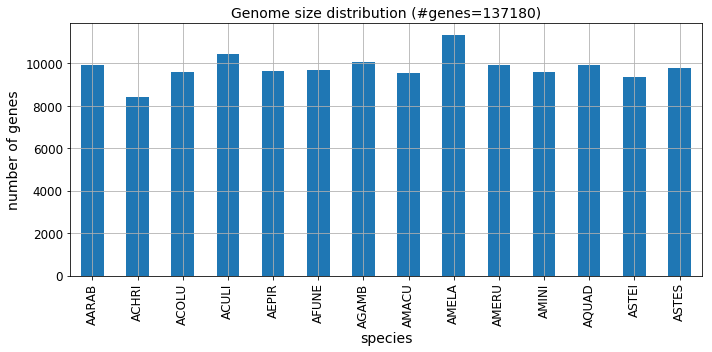

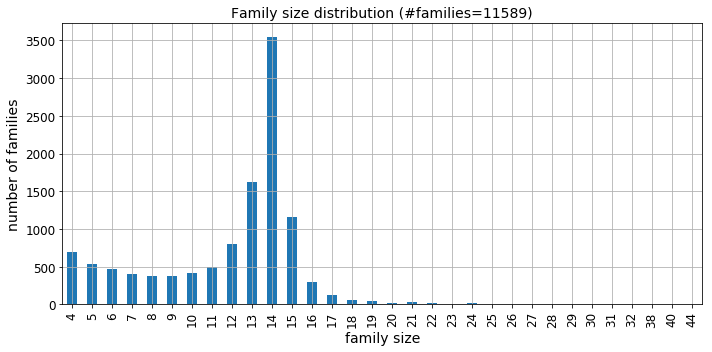

In [8]:
# Plotting statistics
generate_images(GENES_MRB_S5000_RF0,'output/images/genome_sizes_mrb_s5000_rf0.png','output/images/family_sizes_mrb_s5000_rf0.png')

Result: output/images/family_sizes_mrb_s5000_rf0.png

<center><img src="output/images/family_sizes_mrb_s5000_rf0.png" width=700px></center>

In [9]:
# Writing the selected genes in a file at the same format than the orthogroups file
GENES_MRB_S5000_RF0_FILE=open('output/files/OG_MRB_S5000_RF0','w')
for idx,row in GENES_MRB_S5000_RF0.iterrows():
    GENES_MRB_S5000_RF0_FILE.write(row['species']+'\t'+row['chr']+'\t'+row['orthogroup']+'\t'+idx+'\t'+row['sign']+'\t'+str(row['start'])+'\t'+str(row['end'])+'\tXX\tXX\n')

### Observed horizontal gene transfers

We consider the results of ALE, keeping only the HGTs sampled with frequence at least 1%

In [10]:
# Filtering the HGTs to keep only the ones from selected families
print('Filtering HGT with frequency>=0.001 5000 MrBayes samples and RF distance 0')
(nb_hgt_pre,nb_hgt_post) = filter_HGT('input/ALE_1000_HGT_001',OG_MRB_S5000_RF0,'output/files/ALE_1000_HGT_001_FILTERED')
print('Number of HGT pre families filtering: '+str(nb_hgt_pre))
print('Number of HGT post families filtering: '+str(nb_hgt_post))

Filtering HGT with frequency>=0.001 5000 MrBayes samples and RF distance 0
Number of HGT pre families filtering: 999161
Number of HGT post families filtering: 854014


In [11]:
# Creating a data frame of the above HGTs while filtering out the ones with frequency < 0.2
HGT_MRB_S5000_RF0_TF20 = read_HGT('output/files/ALE_1000_HGT_001_FILTERED',0.2)
# More statistics on HGTs
print("Number of HGT post min. frequency filtering >= 0.2: ", len(HGT_MRB_S5000_RF0_TF20.loc[HGT_MRB_S5000_RF0_TF20['frequency']>=0.2]))
print("Number of HGT post min. frequency filtering >= 0.5: ", len(HGT_MRB_S5000_RF0_TF20.loc[HGT_MRB_S5000_RF0_TF20['frequency']>=0.5]))
print("Number of HGT post min. frequency filtering >= 0.8: ", len(HGT_MRB_S5000_RF0_TF20.loc[HGT_MRB_S5000_RF0_TF20['frequency']>=0.8]))

Number of HGT post min. frequency filtering >= 0.2:  16210
Number of HGT post min. frequency filtering >= 0.5:  4771
Number of HGT post min. frequency filtering >= 0.8:  1778


### Figure 4: distribution of HGT frequency for HGT with frequence >= 0.2

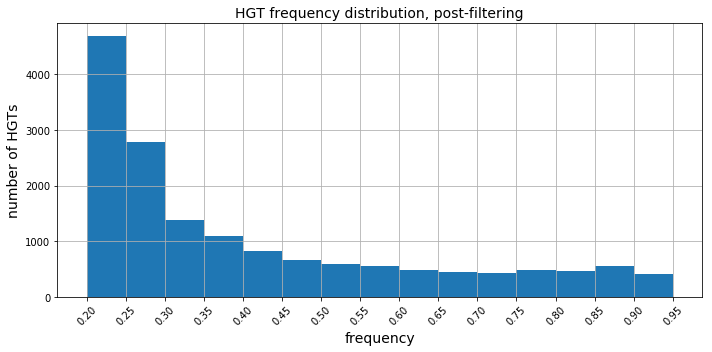

In [12]:
pltHGT = HGT_MRB_S5000_RF0_TF20.hist(column='frequency',bins=np.arange(0.2,1.0,0.05),grid=True,figsize=(10,5))
plt.xticks(np.arange(0.2,1,0.05), rotation=45)
plt.xlabel('frequency', fontsize=14)
plt.ylabel('number of HGTs', fontsize=14)
plt.title('HGT frequency distribution, post-filtering', fontsize=14)
plt.tight_layout()
plt.savefig('output/images/hgt_mrb_s5000_rf0_tf20_frequency.png') 

Result: output/images/hgt_mrb_s5000_rf0_tf20_frequency.png

<center><img src="output/images/hgt_mrb_s5000_rf0_tf20_frequency.png" width=700px></center>

### MaxTiC consistency analysis

In [13]:
# Level of conflict
FREQ_RANGE = [20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95]

MAXTIC_KEPT_DISC_SUMMARY_AUX = {}
for f in FREQ_RANGE:
    KEPT_FILE = 'input/MaxTiC_'+str(f)+'/ALE_1000_HGT_01_'+str(f)+'_1_kept'
    (nk,wk)=read_constraints(KEPT_FILE)
    DISC_FILE = 'input/MaxTiC_'+str(f)+'/ALE_1000_HGT_01_'+str(f)+'_1_discarded'
    (nd,wd)=read_constraints(DISC_FILE)
    MAXTIC_KEPT_DISC_SUMMARY_AUX[f] = (nk,wk,nd,wd,wk/(wk+wd))
        
MAXTIC_KEPT_DISC_SUMMARY = pd.DataFrame.transpose(pd.DataFrame(MAXTIC_KEPT_DISC_SUMMARY_AUX))
MAXTIC_KEPT_DISC_SUMMARY.columns=['kept_constraints', 'weight', 'discarded_constraints', 'weight', 'weight_ratio']
cols = ['kept_constraints', 'discarded_constraints']
MAXTIC_KEPT_DISC_SUMMARY[cols] = MAXTIC_KEPT_DISC_SUMMARY[cols].applymap(np.int64)

print("Table of kept and discarded constraints per minimum frequency of HGT used to define constraints")
MAXTIC_KEPT_DISC_SUMMARY

Table of kept and discarded constraints per minimum frequency of HGT used to define constraints


,kept_constraints,weight,discarded_constraints,weight,weight_ratio
20,39,4464.978,35,447.840,0.908843
25,32,4172.676,31,377.050,0.917127
30,29,3877.516,23,315.326,0.924794
35,25,3626.852,19,285.850,0.926943
40,21,3359.890,17,245.530,0.931900
45,20,3156.614,16,220.198,0.934791
50,18,2983.730,14,196.538,0.938201
55,15,2823.456,13,164.976,0.944795
60,13,2658.032,10,138.578,0.950448
65,10,2473.694,10,117.980,0.954477


In [14]:
# Ranking constraints details: kept constraints

KEPT_RANGE = ['18,24','25,24','14,24','18,15','23,24','14,15']
MAXTIC_KEPT_AUX = {}
for f in FREQ_RANGE:
    KEPT_FILE = open('input/MaxTiC_'+str(f)+'/ALE_1000_HGT_01_'+str(f)+'_1_kept','r').readlines()
    KEPT_LIST={}
    for l in KEPT_FILE:
        l1=l.rstrip().split()
        if l1[0] in KEPT_RANGE:
            KEPT_LIST[l1[0]] = float(l1[1])
    MAXTIC_KEPT_AUX[f] = []
    for oy in KEPT_RANGE:
        if oy in KEPT_LIST.keys():
            MAXTIC_KEPT_AUX[f].append(KEPT_LIST[oy])
        else:
            MAXTIC_KEPT_AUX[f].append(0) 
MAXTIC_KEPT = pd.DataFrame.transpose(pd.DataFrame(MAXTIC_KEPT_AUX))
MAXTIC_KEPT.columns = KEPT_RANGE
            
print("Table of significant kept ranking constraints per minimum frequency of HGT used to define constraints")
MAXTIC_KEPT

Table of significant kept ranking constraints per minimum frequency of HGT used to define constraints


,"18,24","25,24","14,24","18,15","23,24","14,15"
20,53.194,65.328,68.552,366.514,682.928,3077.384
25,38.876,44.942,52.838,324.466,628.380,2975.468
30,29.388,25.906,38.732,276.076,572.360,2857.636
35,21.580,13.666,28.530,253.674,500.542,2754.516
40,14.840,5.424,14.996,226.978,385.866,2669.926
45,5.738,2.962,8.242,207.642,313.780,2583.114
50,3.854,1.022,5.382,193.426,262.204,2488.406
55,3.854,0.000,1.284,170.290,226.754,2398.168
60,2.656,0.000,1.284,154.020,180.812,2298.486
65,0.000,0.000,0.000,135.364,137.150,2183.444


In [15]:
# Ranking constraints details: discarded constraints

DISC_RANGE = ['15,19','22,25','15,18','15,14']        
MAXTIC_DISC_AUX = {}
for f in FREQ_RANGE:
    DISC_FILE = open('input/MaxTiC_'+str(f)+'/ALE_1000_HGT_01_'+str(f)+'_1_discarded','r').readlines()
    DISC_LIST={}
    for l in DISC_FILE:
        l1=l.rstrip().split()
        if l1[0] in DISC_RANGE:
            DISC_LIST[l1[0]] = float(l1[1])
    MAXTIC_DISC_AUX[f] = []
    for oy in DISC_RANGE:
        if oy in DISC_LIST.keys():
            MAXTIC_DISC_AUX[f].append(DISC_LIST[oy])
        else:
            MAXTIC_DISC_AUX[f].append(0) 
MAXTIC_DISC = pd.DataFrame.transpose(pd.DataFrame(MAXTIC_DISC_AUX))
MAXTIC_DISC.columns = DISC_RANGE
            
print("Table of significant discarded ranking constraints per minimum frequency of HGT used to define  constraints")
MAXTIC_DISC

Table of significant discarded ranking constraints per minimum frequency of HGT used to define  constraints


,"15,19","22,25","15,18","15,14"
20,26.344,35.692,50.632,218.256
25,20.630,31.242,43.542,194.222
30,15.700,25.174,36.516,172.902
35,15.056,22.674,33.396,159.304
40,10.598,15.920,26.688,148.908
45,7.190,12.532,24.098,138.820
50,5.368,7.804,24.098,127.368
55,5.368,5.706,17.804,112.618
60,4.188,0.000,14.352,98.840
65,4.188,0.000,10.578,88.778


### Figure 5: potential introgression events
They are obtained from HGTs appearing in at least 50 orthogroups with frequency >= 0.5 and whose accumulated frequency is at least 50.

Number of HGT post min. frequency filtering:  4771


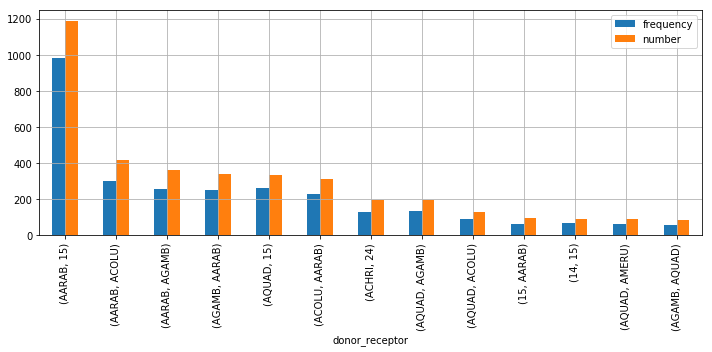

In [16]:
HGT_MRB_S5000_RF0_TF50 = read_HGT('output/ALE_1000_HGT_001_FILTERED',0.5)
print("Number of HGT post min. frequency filtering: ", len(HGT_MRB_S5000_RF0_TF50))
HGT_AGG_S5000_RF0_TF50           = aggregate_HGT(HGT_MRB_S5000_RF0_TF50)
HGT_AGG_S5000_RF0_TF50_N50_CF50  = filter_introgression(HGT_AGG_S5000_RF0_TF50,50,50,'output/images/HGT_agg_s5000_rf0_tf50_n50_cf50.png')

### Orthogroups support for individual introgression events

In [17]:
# Recording interesting introgression events
INTRO_EVENTS_50_100_75 = [('AARAB','15'),('AARAB','ACOLU'),('AGAMB','AARAB'),('AARAB','AGAMB'),('AQUAD','15'),('ACHRI','24'),('AQUAD','AGAMB'),('AQUAD','ACOLU')]
INTRO_EVENTS_50_50_50  = INTRO_EVENTS_50_100_75+[('15','AARAB'),('AQUAD','AMERU'),('14','15')]
INTRO_EVENTS_20_100_75 = INTRO_EVENTS_50_100_75+[('15','AARAB'),('AMACU','ACULI'),('AQUAD','AMERU'),('AGAMB','AQUAD'),('14','15'),('AMERU','AQUAD')]

In [18]:
OG_S5000_RF0_TF50_ACHRI_24 = extract_introg_event_families(HGT_MRB_S5000_RF0_TF50,ORTHOGROUPS,'ACHRI','24','S5000_RF0_TF50.txt')
ACHRI_24_mean     = OG_S5000_RF0_TF50_ACHRI_24['frequency'].mean()
ACHRI_24_nb       = len(OG_S5000_RF0_TF50_ACHRI_24)
ACHRI_NB_coverage = OG_S5000_RF0_TF50_ACHRI_24['nb_species'].mean()

In [19]:
# Checking families interesting introgression events
OG_INTRO_EVENTS_50_100_75={}
for (X,Y) in INTRO_EVENTS_50_100_75:
    OG_INTRO_EVENTS_50_100_75[(X,Y)]=extract_introg_event_families(HGT_MRB_S5000_RF0_TF50,ORTHOGROUPS,X,Y,'S5000_RF0_TF50.txt')

OG_INTRO_EVENTS_50_50_50={}
for (X,Y) in INTRO_EVENTS_50_50_50:
    OG_INTRO_EVENTS_50_50_50[(X,Y)]=extract_introg_event_families(HGT_MRB_S5000_RF0_TF50,ORTHOGROUPS,X,Y,'S5000_RF0_TF50.txt')

OG_INTRO_EVENTS_20_100_75={}
for (X,Y) in INTRO_EVENTS_20_100_75:
    OG_INTRO_EVENTS_20_100_75[(X,Y)]=extract_introg_event_families(HGT_MRB_S5000_RF0_TF20,ORTHOGROUPS,X,Y,'S5000_RF0_TF20.txt')

In [20]:
show_support(INTRO_EVENTS_50_50_50,OG_INTRO_EVENTS_50_50_50,'---> HGT frequency 50')
print('\n')
show_support(INTRO_EVENTS_20_100_75,OG_INTRO_EVENTS_20_100_75,'---> HGT frequency 20')

#---> HGT frequency 50
#donor	rec.	#HGTs	avgFreq	covAll	covGamb	covOutg	covAsian
AARAB	15	1189	0.824	13.574	5.817	1.896	5.862
AARAB	ACOLU	418	0.719	12.833	5.624	1.507	5.701
AGAMB	AARAB	342	0.741	13.202	5.673	1.839	5.69
AARAB	AGAMB	361	0.717	12.507	5.211	1.82	5.476
AQUAD	15	332	0.797	13.542	5.783	1.892	5.867
ACHRI	24	195	0.65	13.897	5.938	1.995	5.964
AQUAD	AGAMB	193	0.704	12.938	5.461	1.839	5.637
AQUAD	ACOLU	131	0.7	12.817	5.634	1.481	5.702
15	AARAB	93	0.645	13.699	5.925	1.925	5.849
AQUAD	AMERU	90	0.677	13.156	5.644	1.756	5.756
14	15	90	0.739	13.822	5.9	1.989	5.933


#---> HGT frequency 20
#donor	rec.	#HGTs	avgFreq	covAll	covGamb	covOutg	covAsian
AARAB	15	1819	0.652	13.422	5.752	1.875	5.795
AARAB	ACOLU	887	0.512	12.551	5.486	1.542	5.523
AGAMB	AARAB	674	0.531	12.697	5.475	1.782	5.441
AARAB	AGAMB	775	0.504	12.138	5.062	1.77	5.306
AQUAD	15	622	0.568	13.408	5.715	1.881	5.812
ACHRI	24	780	0.417	13.717	5.918	1.872	5.927
AQUAD	AGAMB	531	0.451	12.316	5.154	1.8	5.362
AQUAD	ACOLU	314	0.468	12.159